In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 12

def connection():
    db_params = {
        'dbname': 'russian-stocks-prediction-ml-dl',
        'user': 'root',
        'password': 'groot',
        'host': '185.70.105.233',
        'port': '5432'
    }
    conn_str = f'postgresql+psycopg2://{db_params["user"]}:{db_params["password"]}@{db_params["host"]}:{db_params["port"]}/{db_params["dbname"]}'
    return create_engine(conn_str)

In [3]:
print("ЗАГРУЗКА ДАННЫХ ЦБ РФ...")

df = pd.read_sql("SELECT * FROM cbrf_data ORDER BY date", connection())

print(f"Загружено данных: {len(df)} записей")
print(f"Период: {df['date'].min().date()} - {df['date'].max().date()}")
print(f"Показателей: {len(df.columns)}")

# Основная информация
print("\nОСНОВНАЯ ИНФОРМАЦИЯ:")
df.info()

ЗАГРУЗКА ДАННЫХ ЦБ РФ...
Загружено данных: 106 записей
Период: 2017-01-01 - 2025-10-01
Показателей: 32

ОСНОВНАЯ ИНФОРМАЦИЯ:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            106 non-null    datetime64[ns]
 1   credit_rate_1y_inc_demand       105 non-null    float64       
 2   credit_rate_30d_inc_demand      105 non-null    float64       
 3   credit_rate_1y_3y               105 non-null    float64       
 4   credit_rate_181d_1y             105 non-null    float64       
 5   credit_rate_31_90d              105 non-null    float64       
 6   credit_rate_91_180d             105 non-null    float64       
 7   credit_rate_over_1y             105 non-null    float64       
 8   credit_rate_over_3y             105 non-null    float64       
 9   deposit_rate_dema

In [6]:
print("БАЗОВАЯ СТАТИСТИКА ДАННЫХ ЦБ РФ")
print("=" * 50)

print("Основные статистики:")
print(df.describe())

print(f"\nПРОПУЩЕННЫЕ ЗНАЧЕНИЯ:")
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Пропущено': missing_data, '%': missing_percent})
print(missing_df[missing_df['Пропущено'] > 0].sort_values('%', ascending=False))


БАЗОВАЯ СТАТИСТИКА ДАННЫХ ЦБ РФ
Основные статистики:
                                date  credit_rate_1y_inc_demand  \
count                            106                 105.000000   
mean   2021-05-16 21:44:09.056603648                  19.178381   
min              2017-01-01 00:00:00                  13.040000   
25%              2019-03-08 18:00:00                  14.930000   
50%              2021-05-16 12:00:00                  18.350000   
75%              2023-07-24 06:00:00                  21.230000   
max              2025-10-01 00:00:00                  32.730000   
std                              NaN                   4.889498   

       credit_rate_30d_inc_demand  credit_rate_1y_3y  credit_rate_181d_1y  \
count                  105.000000         105.000000           105.000000   
mean                    22.138286          17.182952            17.862762   
min                     10.580000          12.800000            12.980000   
25%                     13.850000  

АНАЛИЗ ПРОЦЕНТНЫХ СТАВОК
Кредитные ставки (8):
   - credit_rate_1y_inc_demand
   - credit_rate_30d_inc_demand
   - credit_rate_1y_3y
   - credit_rate_181d_1y
   - credit_rate_31_90d
   - credit_rate_91_180d
   - credit_rate_over_1y
   - credit_rate_over_3y

Депозитные ставки (11):
   - deposit_rate_demand
   - deposit_rate_1y_inc_demand
   - deposit_rate_1y_excl_demand
   - deposit_rate_30d_inc_demand
   - deposit_rate_30d_excl_demand
   - deposit_rate_1y_3y
   - deposit_rate_181d_1y
   - deposit_rate_31_90d
   - deposit_rate_91_180d
   - deposit_rate_over_1y
   - deposit_rate_over_3y


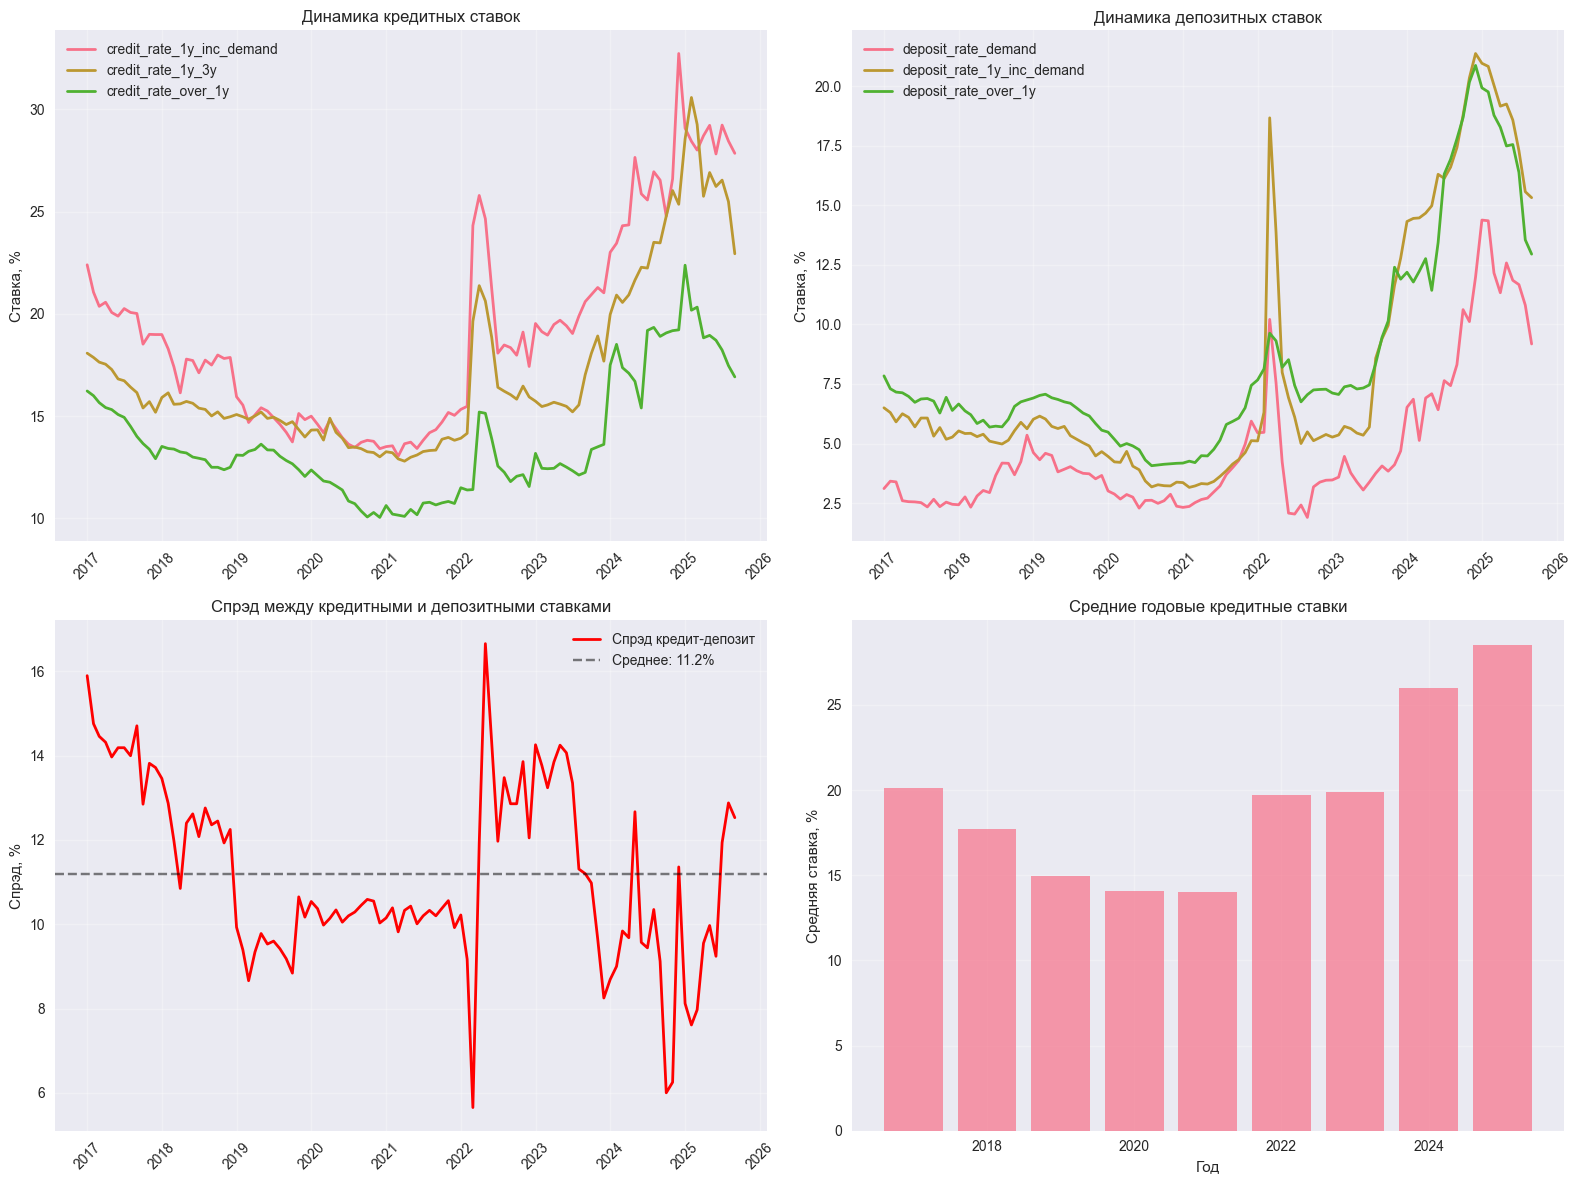

In [8]:
print("АНАЛИЗ ПРОЦЕНТНЫХ СТАВОК")
print("=" * 50)

credit_rates = [col for col in df.columns if 'credit_rate' in col]
deposit_rates = [col for col in df.columns if 'deposit_rate' in col]

print(f"Кредитные ставки ({len(credit_rates)}):")
for rate in credit_rates:
    print(f"   - {rate}")

print(f"\nДепозитные ставки ({len(deposit_rates)}):")
for rate in deposit_rates:
    print(f"   - {rate}")

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
key_credit_rates = ['credit_rate_1y_inc_demand', 'credit_rate_1y_3y', 'credit_rate_over_1y']
for rate in key_credit_rates:
    if rate in df.columns:
        plt.plot(df['date'], df[rate], label=rate, linewidth=2)
plt.title('Динамика основных кредитных ставок')
plt.ylabel('Ставка, %')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
key_deposit_rates = ['deposit_rate_demand', 'deposit_rate_1y_inc_demand', 'deposit_rate_over_1y']
for rate in key_deposit_rates:
    if rate in df.columns:
        plt.plot(df['date'], df[rate], label=rate, linewidth=2)
plt.title('Динамика основных депозитных ставок')
plt.ylabel('Ставка, %')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
if 'credit_rate_1y_inc_demand' in df.columns and 'deposit_rate_1y_inc_demand' in df.columns:
    spread = df['credit_rate_1y_inc_demand'] - df['deposit_rate_1y_inc_demand']
    plt.plot(df['date'], spread, color='red', linewidth=2, label='Спрэд кредит-депозит')
    plt.axhline(y=spread.mean(), color='black', linestyle='--', alpha=0.5, label=f'Среднее: {spread.mean():.1f}%')
    plt.title('Спрэд между кредитными и депозитными ставками')
    plt.ylabel('Спрэд, %')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
if 'credit_rate_1y_inc_demand' in df.columns:
    yearly_avg = df.groupby(df['date'].dt.year)['credit_rate_1y_inc_demand'].mean()
    plt.bar(yearly_avg.index, yearly_avg.values, alpha=0.7)
    plt.title('Средние годовые кредитные ставки')
    plt.xlabel('Год')
    plt.ylabel('Средняя ставка, %')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Денежные агрегаты и кредиты:
   loan_volume_foreign: 80 записей
   loan_volume_rub: 80 записей
   loan_volume_total: 80 записей
   broad_money_total: 104 записей
   broad_money_m2: 104 записей
   broad_money_certificates: 104 записей
   broad_money_foreign_households: 104 записей
   broad_money_foreign_finorgs: 104 записей
   broad_money_foreign_nonfin: 104 записей


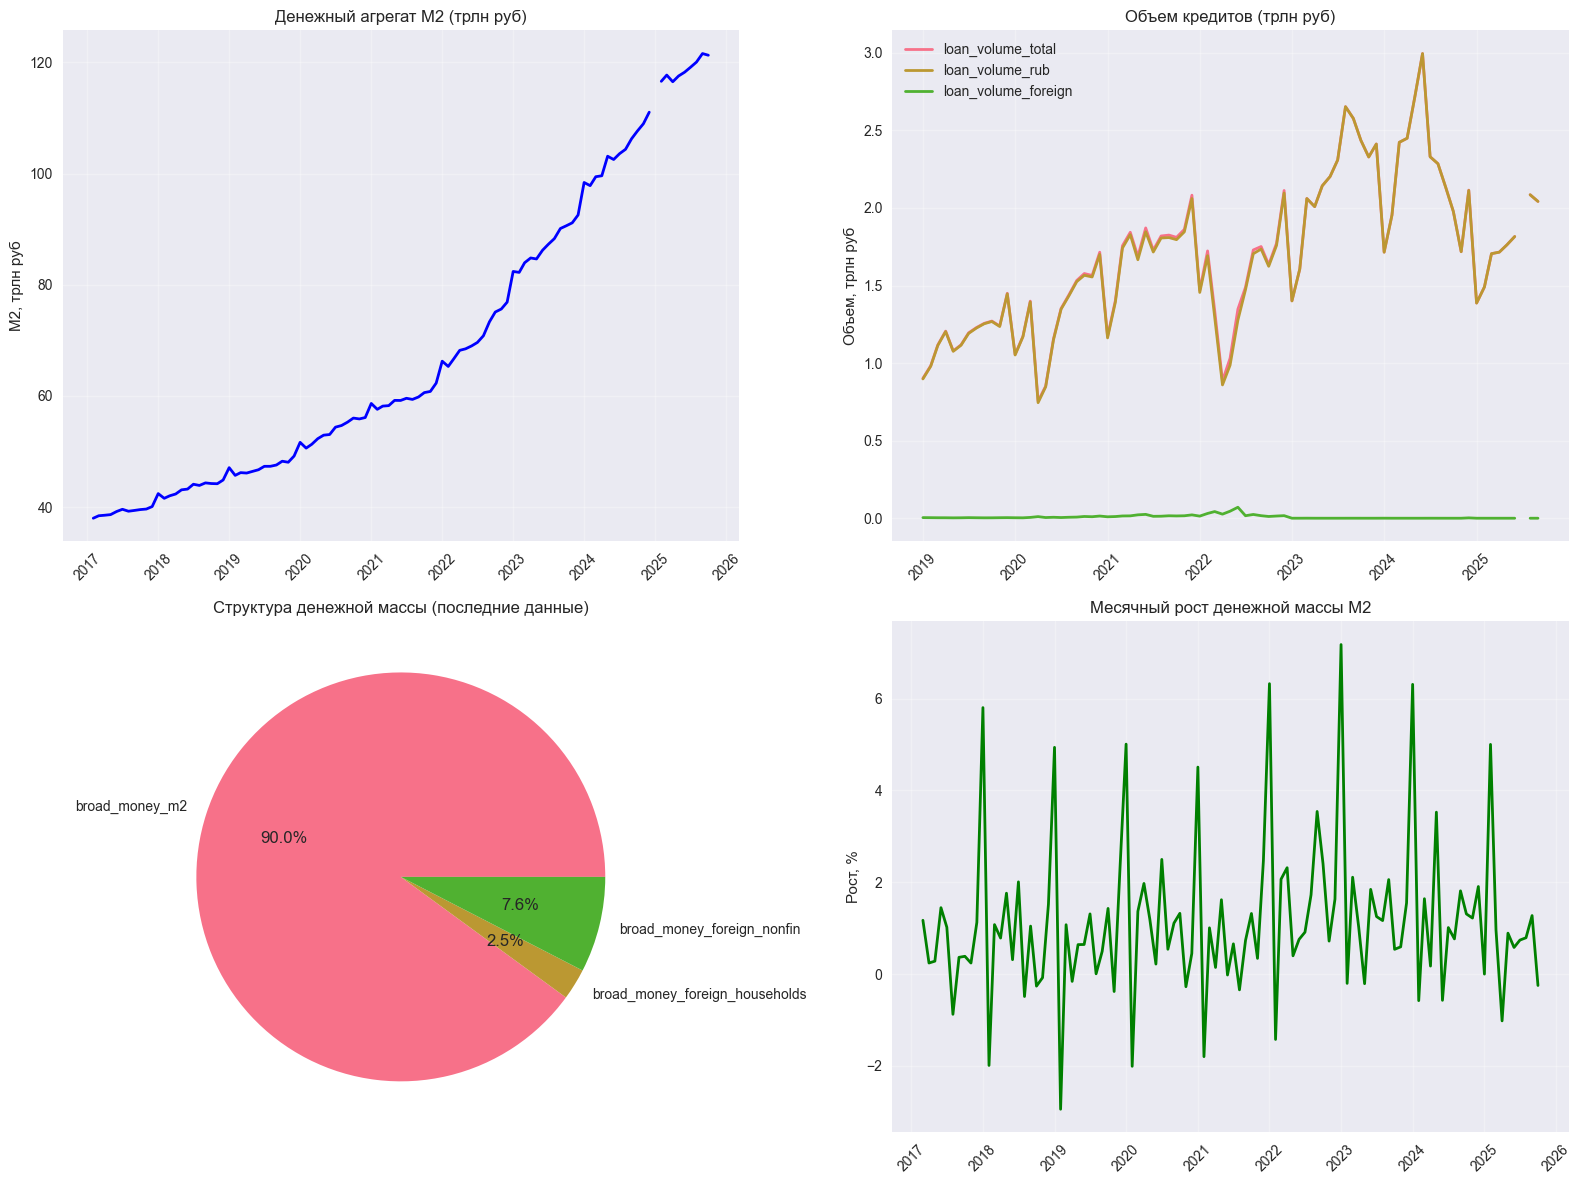

In [12]:
money_columns = [col for col in df.columns if 'broad_money' in col or 'loan_volume' in col]

print("Денежные агрегаты и кредиты:")
for col in money_columns:
    non_null = df[col].notna().sum()
    print(f"   {col}: {non_null} записей")

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
if 'broad_money_m2' in df.columns:
    plt.plot(df['date'], df['broad_money_m2'] / 1000, linewidth=2, color='blue')
    plt.title('Денежный агрегат M2 (трлн руб)')
    plt.ylabel('M2, трлн руб')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
loan_cols = ['loan_volume_total', 'loan_volume_rub', 'loan_volume_foreign']
for col in loan_cols:
    if col in df.columns and df[col].notna().sum() > 0:
        plt.plot(df['date'], df[col] / 1e6, label=col, linewidth=2)
plt.title('Объем кредитов (трлн руб)')
plt.ylabel('Объем, трлн руб')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
structure_cols = ['broad_money_m2', 'broad_money_foreign_households', 
                  'broad_money_foreign_nonfin']
if all(col in df.columns for col in structure_cols):
    recent_data = df[structure_cols].iloc[-1] / 1000  # в трлн руб
    recent_data = recent_data[recent_data.notna()]
    if len(recent_data) > 0:
        plt.pie(recent_data.values, labels=recent_data.index, autopct='%1.1f%%')
        plt.title('Структура денежной массы (последние данные)')

plt.subplot(2, 2, 4)
if 'broad_money_m2' in df.columns:
    df_sorted = df.sort_values('date')
    df_sorted['m2_growth'] = df_sorted['broad_money_m2'].pct_change() * 100
    plt.plot(df_sorted['date'], df_sorted['m2_growth'], color='green', linewidth=2)
    plt.title('Месячный рост денежной массы M2')
    plt.ylabel('Рост, %')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

АНАЛИЗ КУРСОВ ВАЛЮТ
АКТУАЛЬНЫЕ ДАННЫЕ ПО КУРСАМ ВАЛЮТ:
   usd_rub_end:
      Последнее значение: 82.87 (на 2025-09-01)
      Всего записей: 105
      Изменение за год: -10.6%
      Изменение за весь период: +37.7%
   eur_rub_end:
      Последнее значение: 97.14 (на 2025-09-01)
      Всего записей: 105
      Изменение за год: -6.1%
      Изменение за весь период: +50.8%
   cny_rub_end:
      Последнее значение: 11.60 (на 2025-09-01)
      Всего записей: 33
      Изменение за год: -12.2%
      Изменение за весь период: +12.5%

ДЕТАЛЬНАЯ СТАТИСТИКА КУРСОВ ВАЛЮТ:

   usd_rub_end:
      Период данных: 2017-01-01 - 2025-09-01
      Минимальный: 51.16
      Максимальный: 107.74
      Средний: 73.24
      Медиана: 72.76
      Стандартное отклонение: 12.53
      25-й процентиль: 63.04
      75-й процентиль: 81.56

   eur_rub_end:
      Период данных: 2017-01-01 - 2025-09-01
      Минимальный: 53.86
      Максимальный: 114.31
      Средний: 82.01
      Медиана: 82.29
      Стандартное отклонение

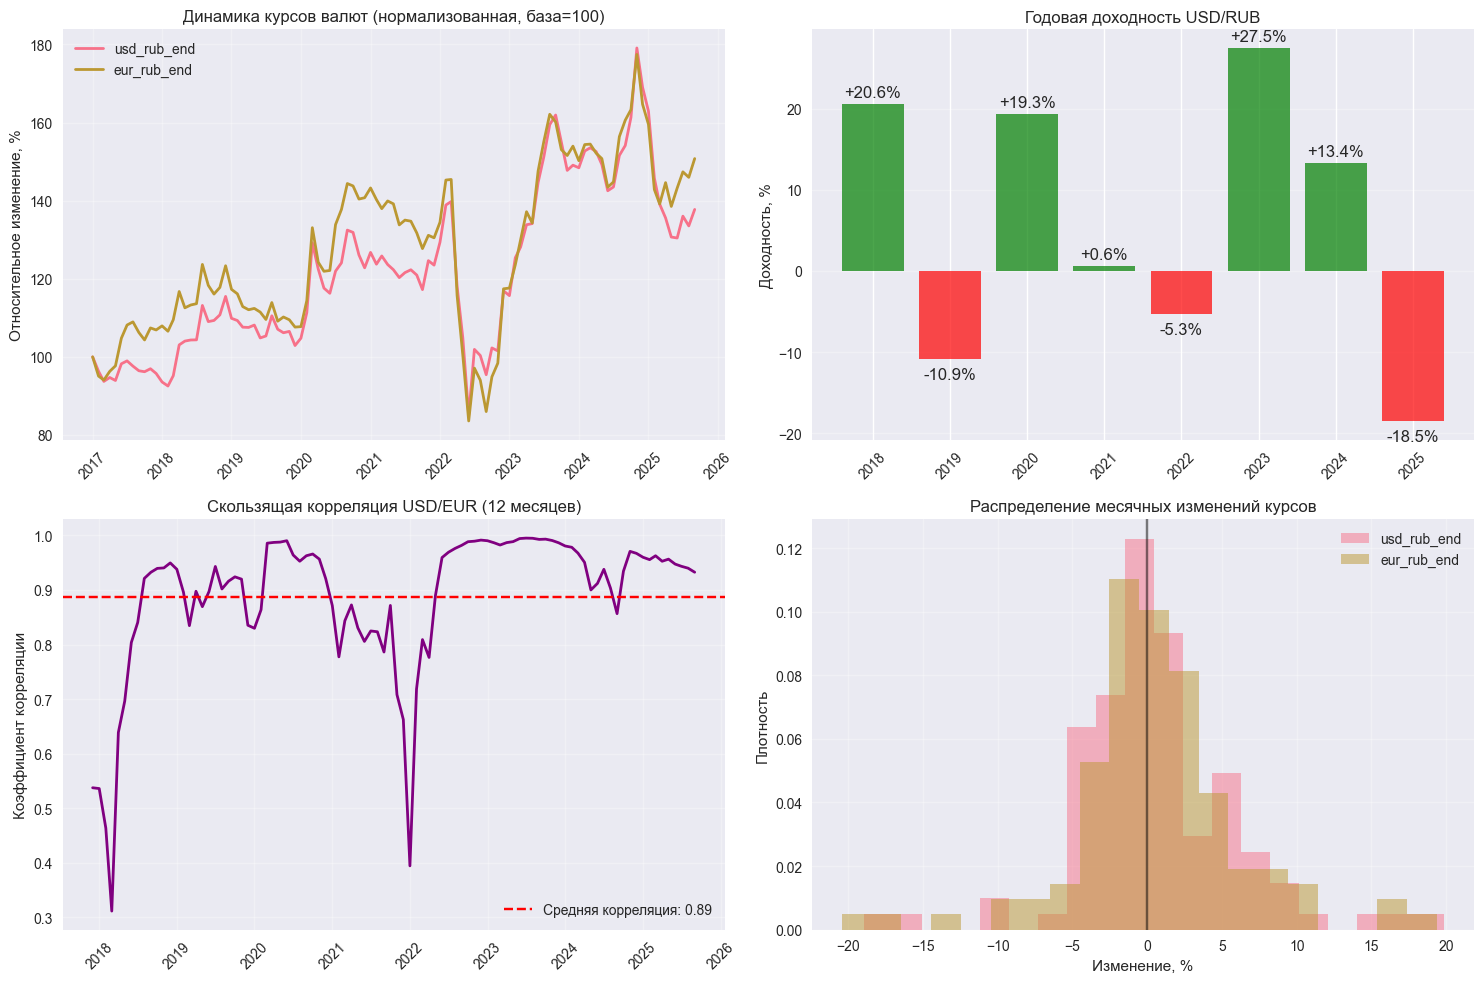


   usd_rub_end:
      Самый большой рост:
        2022-07-01: +19.8%
        2020-03-01: +16.0%
        2022-12-01: +15.2%
      Самые большие падения:
        2022-06-01: -18.9%
        2022-04-01: -15.5%
        2022-05-01: -11.2%

   eur_rub_end:
      Самый большой рост:
        2022-12-01: +19.4%
        2020-03-01: +16.3%
        2022-07-01: +16.2%
      Самые большие падения:
        2022-04-01: -20.4%
        2022-06-01: -16.8%
        2022-05-01: -13.2%

ПЕРИОДЫ ВЫСОКОЙ ВОЛАТИЛЬНОСТИ:
   Периоды самой высокой волатильности USD/RUB:
      2022-12-01: 40.5%
      2023-03-01: 40.5%
      2023-02-01: 40.4%
      2023-01-01: 40.2%
      2022-10-01: 37.8%


In [20]:
print("АНАЛИЗ КУРСОВ ВАЛЮТ")
print("=" * 50)

df_analysis = df.copy().sort_values('date')

for currency in ['usd_rub_end', 'eur_rub_end', 'cny_rub_end']:
    if currency in df_analysis.columns:
        df_analysis[f'{currency}_returns'] = df_analysis[currency].pct_change()

def get_last_valid_value(series):
    valid_values = series.dropna()
    return valid_values.iloc[-1] if len(valid_values) > 0 else None

print("АКТУАЛЬНЫЕ ДАННЫЕ ПО КУРСАМ ВАЛЮТ:")
for currency in ['usd_rub_end', 'eur_rub_end', 'cny_rub_end']:
    if currency in df_analysis.columns:
        non_null = df_analysis[currency].notna().sum()
        last_value = get_last_valid_value(df_analysis[currency])
        last_date = df_analysis.loc[df_analysis[currency].last_valid_index(), 'date'] if df_analysis[currency].last_valid_index() else None
        
        if last_value:
            print(f"   {currency}:")
            print(f"      Последнее значение: {last_value:.2f} (на {last_date.date()})")
            print(f"      Всего записей: {non_null}")
            
            if non_null > 12:  
                one_year_ago = last_date - pd.DateOffset(years=1)
                year_data = df_analysis[df_analysis['date'] >= one_year_ago][currency].dropna()
                if len(year_data) > 1:
                    year_change = ((last_value - year_data.iloc[0]) / year_data.iloc[0]) * 100
                    print(f"      Изменение за год: {year_change:+.1f}%")
                
                first_value = df_analysis[currency].dropna().iloc[0]
                total_change = ((last_value - first_value) / first_value) * 100
                print(f"      Изменение за весь период: {total_change:+.1f}%")

print(f"\nДЕТАЛЬНАЯ СТАТИСТИКА КУРСОВ ВАЛЮТ:")

for currency in ['usd_rub_end', 'eur_rub_end', 'cny_rub_end']:
    if currency in df_analysis.columns and df_analysis[currency].notna().sum() > 0:
        currency_data = df_analysis[currency].dropna()
        
        print(f"\n   {currency}:")
        print(f"      Период данных: {df_analysis.loc[currency_data.index[0], 'date'].date()} - {df_analysis.loc[currency_data.index[-1], 'date'].date()}")
        print(f"      Минимальный: {currency_data.min():.2f}")
        print(f"      Максимальный: {currency_data.max():.2f}")
        print(f"      Средний: {currency_data.mean():.2f}")
        print(f"      Медиана: {currency_data.median():.2f}")
        print(f"      Стандартное отклонение: {currency_data.std():.2f}")
        
        q25, q75 = currency_data.quantile([0.25, 0.75])
        print(f"      25-й процентиль: {q25:.2f}")
        print(f"      75-й процентиль: {q75:.2f}")

print(f"\n АНАЛИЗ ВОЛАТИЛЬНОСТИ ПО ГОДАМ:")

df_analysis['year'] = df_analysis['date'].dt.year

for currency in ['usd_rub_end', 'eur_rub_end']:
    if currency in df_analysis.columns and f'{currency}_returns' in df_analysis.columns:
        yearly_vol = df_analysis.groupby('year')[f'{currency}_returns'].std() * np.sqrt(12) * 100
        
        print(f"\n   {currency}:")
        for year, vol in yearly_vol.items():
            if not pd.isna(vol) and vol > 0:
                print(f"      {year}: {vol:.1f}%")

print(f"\nСРАВНИТЕЛЬНЫЙ АНАЛИЗ ДИНАМИКИ:")

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
for currency in ['usd_rub_end', 'eur_rub_end']:
    if currency in df_analysis.columns and df_analysis[currency].notna().sum() > 0:
        first_valid = df_analysis[currency].dropna().iloc[0]
        normalized = (df_analysis[currency] / first_valid) * 100
        plt.plot(df_analysis['date'], normalized, label=currency, linewidth=2)

plt.title('Динамика курсов валют (нормализованная, база=100)')
plt.ylabel('Относительное изменение, %')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
if 'usd_rub_end' in df_analysis.columns and df_analysis['usd_rub_end'].notna().sum() > 12:
    yearly_data = df_analysis.set_index('date')['usd_rub_end'].resample('Y').last()
    yearly_return = yearly_data.pct_change() * 100
    
    years = yearly_return.index.year[1:]
    returns = yearly_return.values[1:]
    
    colors = ['green' if x > 0 else 'red' for x in returns]
    bars = plt.bar(range(len(years)), returns, alpha=0.7, color=colors)
    
    for i, (bar, ret) in enumerate(zip(bars, returns)):
        plt.text(i, bar.get_height() + (0.5 if ret > 0 else -1), 
                f'{ret:+.1f}%', ha='center', va='bottom' if ret > 0 else 'top')
    
    plt.xticks(range(len(years)), years, rotation=45)
    plt.title('Годовая доходность USD/RUB')
    plt.ylabel('Доходность, %')
    plt.grid(True, alpha=0.3, axis='y')

plt.subplot(2, 2, 3)
if 'usd_rub_end' in df_analysis.columns and 'eur_rub_end' in df_analysis.columns:
    usd_clean = df_analysis['usd_rub_end'].dropna()
    eur_clean = df_analysis['eur_rub_end'].dropna()
    
    if len(usd_clean) > 12 and len(eur_clean) > 12:
        combined = pd.DataFrame({
            'usd': usd_clean,
            'eur': eur_clean
        }).dropna()
        
        if len(combined) > 12:
            rolling_corr = combined['usd'].rolling(window=12).corr(combined['eur'])
            dates = df_analysis.loc[combined.index, 'date']
            plt.plot(dates, rolling_corr, color='purple', linewidth=2)
            plt.axhline(y=rolling_corr.mean(), color='red', linestyle='--', 
                        label=f'Средняя корреляция: {rolling_corr.mean():.2f}')
            plt.title('Скользящая корреляция USD/EUR (12 месяцев)')
            plt.ylabel('Коэффициент корреляции')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
    else:
        plt.text(0.5, 0.5, 'Недостаточно данных\nдля анализа корреляции', 
                 ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Корреляция USD/EUR')

plt.subplot(2, 2, 4)
for currency in ['usd_rub_end', 'eur_rub_end']:
    if currency in df_analysis.columns and f'{currency}_returns' in df_analysis.columns:
        returns = df_analysis[f'{currency}_returns'].dropna() * 100
        if len(returns) > 0:
            plt.hist(returns, bins=20, alpha=0.5, label=currency, density=True)

plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.title('Распределение месячных изменений курсов')
plt.xlabel('Изменение, %')
plt.ylabel('Плотность')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

for currency in ['usd_rub_end', 'eur_rub_end']:
    if currency in df_analysis.columns and f'{currency}_returns' in df_analysis.columns:
        returns = df_analysis[f'{currency}_returns'].dropna() * 100
        
        if len(returns) > 0:
            top_gains = returns.nlargest(3)
            top_losses = returns.nsmallest(3)
            
            print(f"\n   {currency}:")
            print(f"      Самый большой рост:")
            for idx, value in top_gains.items():
                date = df_analysis.loc[idx, 'date']
                print(f"        {date.date()}: {value:+.1f}%")
            
            print(f"      Самые большие падения:")
            for idx, value in top_losses.items():
                date = df_analysis.loc[idx, 'date']
                print(f"        {date.date()}: {value:+.1f}%")

print(f"\nПЕРИОДЫ ВЫСОКОЙ ВОЛАТИЛЬНОСТИ:")

if 'usd_rub_end_returns' in df_analysis.columns:
    rolling_vol = df_analysis['usd_rub_end_returns'].rolling(window=12).std() * np.sqrt(12) * 100
    
    high_vol_periods = rolling_vol.nlargest(5)
    
    print("   Периоды самой высокой волатильности USD/RUB:")
    for idx, vol in high_vol_periods.items():
        if not pd.isna(vol):
            date = df_analysis.loc[idx, 'date']
            print(f"      {date.date()}: {vol:.1f}%")

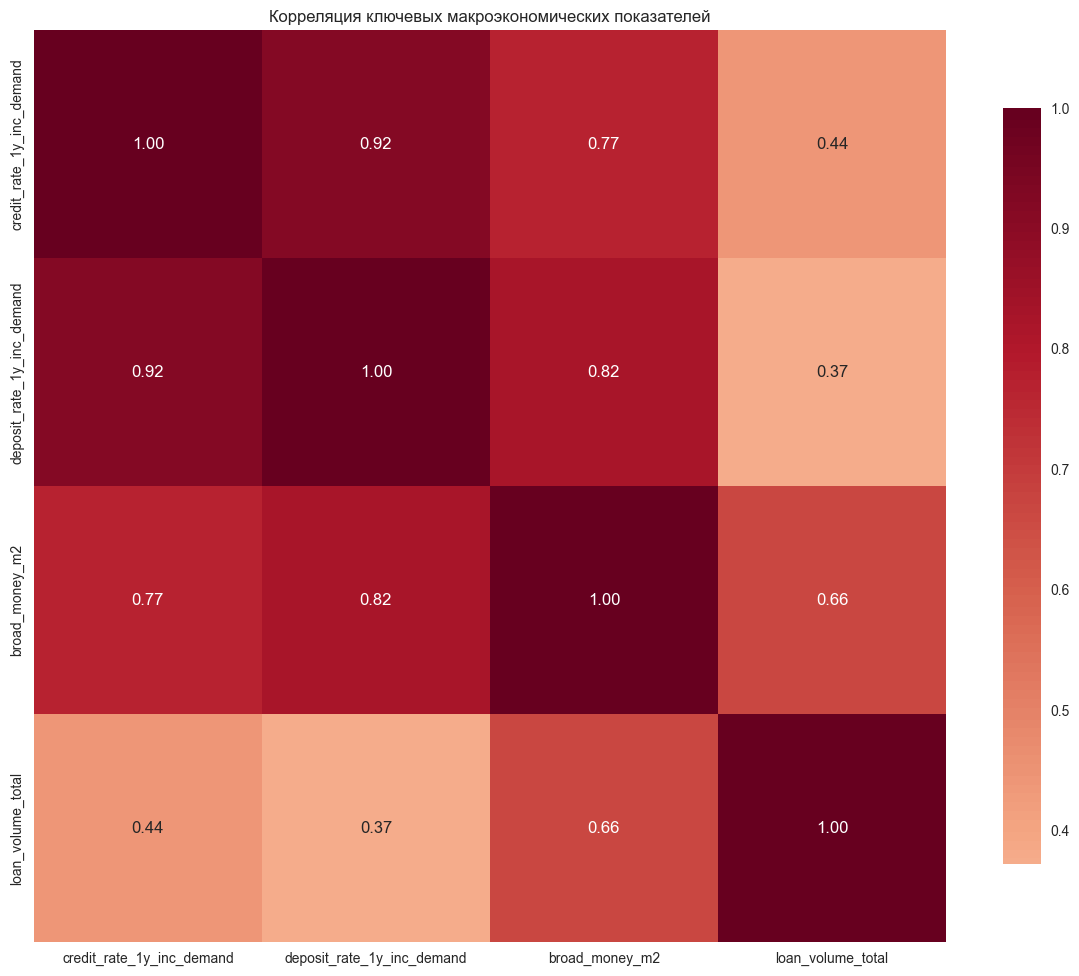


 КЛЮЧЕВЫЕ КОРРЕЛЯЦИИ:
   credit_rate_1y_inc_demand - deposit_rate_1y_inc_demand: 0.92
   credit_rate_1y_inc_demand - broad_money_m2: 0.77
   deposit_rate_1y_inc_demand - broad_money_m2: 0.82
   broad_money_m2 - loan_volume_total: 0.66


In [23]:
key_columns = [
    'credit_rate_1y_inc_demand', 'deposit_rate_1y_inc_demand',
    'broad_money_m2', 'loan_volume_total',
    'usd_rate_end', 'eur_rate_end'
]

available_columns = [col for col in key_columns if col in df.columns]
corr_df = df[available_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, cmap='RdBu_r', center=0, square=True, 
            fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Корреляция ключевых макроэкономических показателей')
plt.tight_layout()
plt.show()

print("\n КЛЮЧЕВЫЕ КОРРЕЛЯЦИИ:")
for i in range(len(corr_df.columns)):
    for j in range(i+1, len(corr_df.columns)):
        corr_value = corr_df.iloc[i, j]
        if abs(corr_value) > 0.5:
            print(f"   {corr_df.columns[i]} - {corr_df.columns[j]}: {corr_value:.2f}")

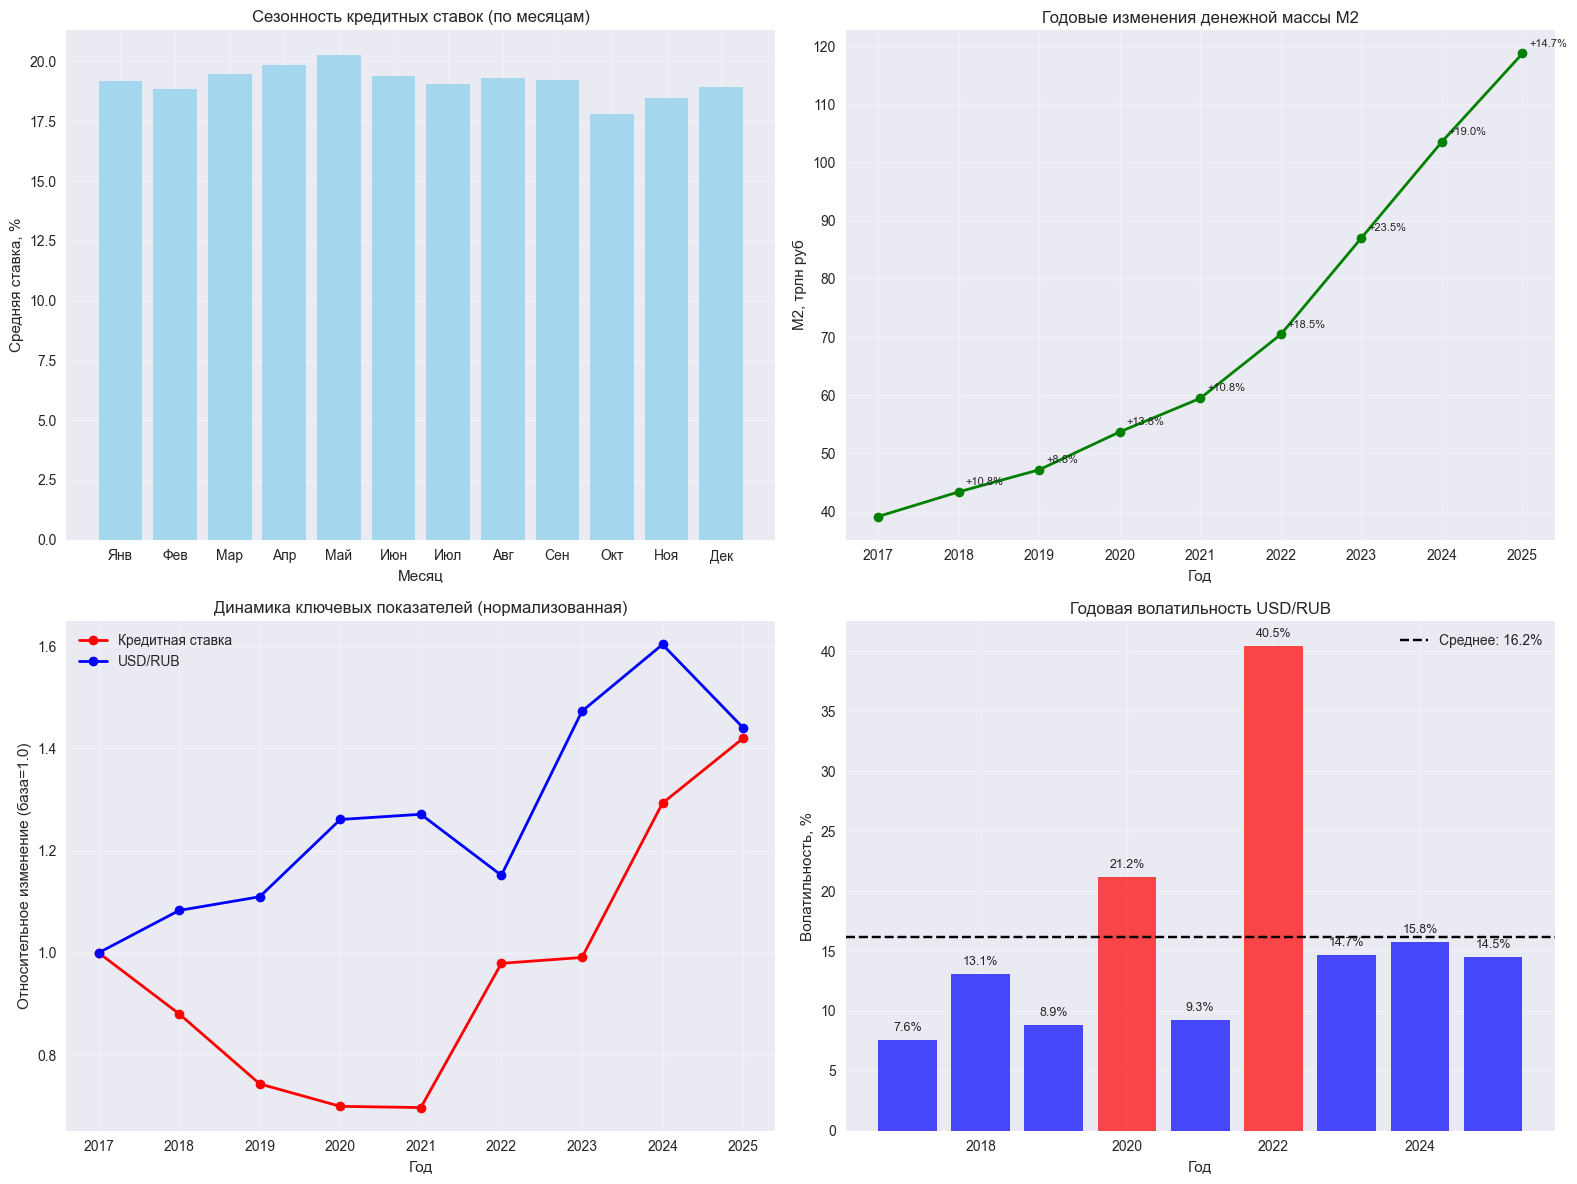

   Квартальные тренды кредитных ставок:
      2017: -11.5%
      2018: -1.8%
      2019: -5.4%
      2020: -6.4%
      2021: +12.0%
      2022: -1.1%
      2023: +9.8%
      2024: +18.8%
      2025: +nan%

   Сезонность денежной массы M2 (средние по месяцам):
      Янв: 63.8 трлн руб
      Фев: 66.2 трлн руб
      Мар: 67.1 трлн руб
      Апр: 67.4 трлн руб
      Май: 68.2 трлн руб
      Июн: 68.6 трлн руб
      Июл: 69.4 трлн руб
      Авг: 69.8 трлн руб
      Сен: 70.9 трлн руб
      Окт: 71.5 трлн руб
      Ноя: 65.5 трлн руб
      Дек: 66.6 трлн руб


In [26]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter

plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
if 'credit_rate_1y_inc_demand' in df.columns:
    seasonal_data = df.groupby('month')['credit_rate_1y_inc_demand'].mean()
    plt.bar(seasonal_data.index, seasonal_data.values, alpha=0.7, color='skyblue')
    plt.title('Сезонность кредитных ставок (по месяцам)')
    plt.xlabel('Месяц')
    plt.ylabel('Средняя ставка, %')
    plt.xticks(range(1, 13), ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 
                             'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
    plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
if 'broad_money_m2' in df.columns:
    yearly_trend = df.groupby('year')['broad_money_m2'].mean() / 1000  # в трлн руб
    plt.plot(yearly_trend.index, yearly_trend.values, marker='o', linewidth=2, color='green')
    plt.title('Годовые изменения денежной массы M2')
    plt.xlabel('Год')
    plt.ylabel('M2, трлн руб')
    plt.grid(True, alpha=0.3)
    
    for i, (year, value) in enumerate(zip(yearly_trend.index, yearly_trend.values)):
        if i > 0:
            growth = ((value - yearly_trend.values[i-1]) / yearly_trend.values[i-1]) * 100
            plt.annotate(f'{growth:+.1f}%', (year, value), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.subplot(2, 2, 3)
comparison_cols = ['credit_rate_1y_inc_demand', 'usd_rub_end']  # ПРАВИЛЬНОЕ НАЗВАНИЕ
available_cols = [col for col in comparison_cols if col in df.columns]

if len(available_cols) >= 2:
    yearly_comparison = df.groupby('year')[available_cols].mean()
    
    first_year = yearly_comparison.index[0]
    yearly_normalized = yearly_comparison / yearly_comparison.loc[first_year]
    
    legend_names = {
        'credit_rate_1y_inc_demand': 'Кредитная ставка',
        'usd_rub_end': 'USD/RUB'
    }
    
    colors = ['red', 'blue']
    for i, col in enumerate(available_cols):
        plt.plot(yearly_normalized.index, yearly_normalized[col], 
                marker='o', linewidth=2, label=legend_names.get(col, col), 
                color=colors[i % len(colors)])
    
    plt.title('Динамика ключевых показателей (нормализованная)')
    plt.xlabel('Год')
    plt.ylabel('Относительное изменение (база=1.0)')
    plt.legend()
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Недостаточно данных\nдля сравнения', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Сравнение показателей по годам')

plt.subplot(2, 2, 4)
if 'usd_rub_end' in df.columns: 
    df_sorted = df.sort_values('date')
    df_sorted['usd_returns'] = df_sorted['usd_rub_end'].pct_change()
    
    yearly_vol = df_sorted.groupby('year')['usd_returns'].std() * np.sqrt(12) * 100
    
    yearly_vol_clean = yearly_vol[yearly_vol.notna() & (yearly_vol > 0)]
    
    if len(yearly_vol_clean) > 0:
        colors = ['red' if vol > yearly_vol_clean.mean() else 'blue' for vol in yearly_vol_clean.values]
        bars = plt.bar(yearly_vol_clean.index, yearly_vol_clean.values, alpha=0.7, color=colors)
        
        for bar, vol in zip(bars, yearly_vol_clean.values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    f'{vol:.1f}%', ha='center', va='bottom', fontsize=9)
        
        plt.axhline(y=yearly_vol_clean.mean(), color='black', linestyle='--', 
                   label=f'Среднее: {yearly_vol_clean.mean():.1f}%')
        plt.title('Годовая волатильность USD/RUB')
        plt.xlabel('Год')
        plt.ylabel('Волатильность, %')
        plt.legend()
        plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if 'credit_rate_1y_inc_demand' in df.columns:
    quarterly_trend = df.groupby(['year', 'quarter'])['credit_rate_1y_inc_demand'].mean().reset_index()
    
    print("   Квартальные тренды кредитных ставок:")
    for year in sorted(df['year'].unique()):
        year_data = quarterly_trend[quarterly_trend['year'] == year]
        if len(year_data) > 0:
            change = ((year_data['credit_rate_1y_inc_demand'].iloc[-1] - 
                      year_data['credit_rate_1y_inc_demand'].iloc[0]) / 
                     year_data['credit_rate_1y_inc_demand'].iloc[0]) * 100
            print(f"      {year}: {change:+.1f}%")

if 'broad_money_m2' in df.columns:
    monthly_money = df.groupby('month')['broad_money_m2'].mean() / 1000
    
    print(f"\n   Сезонность денежной массы M2 (средние по месяцам):")
    for month in range(1, 13):
        if month in monthly_money.index:
            value = monthly_money[month]
            month_name = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 
                         'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'][month-1]
            print(f"      {month_name}: {value:.1f} трлн руб")